# Task 2. Topic Modelling

In order to perform topic analysis we are using the following modules (see requirements.txt in order to set the virtual environment):

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from nltk.corpus import PlaintextCorpusReader
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy



Once again we build the document corpus:

In [2]:
docs_dir = './documents_challenge/'
documents = PlaintextCorpusReader(docs_dir, '.*')

These time instead of tabular data we need data stored in a list. We decide to run a topic model for every language so we build the function `generate_list_data()` that takes the corpus and returns three lists, one for the texts of each language:

In [3]:
def generate_list_data(corpus):
    english_texts = []
    french_texts = []
    spanish_texts = []
    for title in corpus.fileids():
        if '/en/' in title:
            english_texts.append(corpus.raw(title))
        elif '/fr/' in title:
            french_texts.append(corpus.raw(title))
        else:
            spanish_texts.append(corpus.raw(title))
    return english_texts, french_texts, spanish_texts

In [4]:
english_texts, french_texts, spanish_texts = generate_list_data(documents)

We check that every text has been classified:

In [5]:
len(english_texts) + len(french_texts) + len(spanish_texts) 

23128

The `evaluate_graph()` function builds every LDA model and computes its coherence. This allows us to check what would be the optimal number of topics: 

In [6]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v


## Spanish Modelling

In order to preprocess the data for our LDA we extract the bigrams and then lematize using a specific model for Spanish:

In [13]:
bigram = gensim.models.Phrases(spanish_texts)

In [ ]:
!python -m spacy download es_core_news_md

In [17]:
nlp = spacy.load('/home/arturosanchez/Entornos_Virtuales/ea_assessment/lib/python3.6/site-packages/es_core_news_md/es_core_news_md-2.3.1')

In [18]:
def cleaner_spanish(spanish_texts,word, bigram, nlp):
    stop = set(stopwords.words('spanish'))
    stop_words = stop
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    list_word_clean = []
    for w1 in word.split(" "):
        if  w1.lower() not in stop_words:
            list_word_clean.append(w1.lower())
    bigram_list = bigram[list_word_clean]
    out_text = lemmatization_spanish(" ".join(bigram_list), stop_words, nlp)
    return out_text

In [19]:
def lemmatization_spanish(texts, stop_words, nlp, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stop_words and len(token.text)>2]
    return texts_out

In [21]:
spanish_cleaned = [cleaner_spanish(spanish_texts, x, bigram, nlp) for x in spanish_texts]

In [22]:
dictionary_spanish = Dictionary(spanish_cleaned)
dictionary_spanish.compactify()
dictionary_spanish.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary_spanish.compactify()

corpus_spanish = [dictionary_spanish.doc2bow(text) for text in spanish_cleaned]

We check the suggest number of topics for lsi and lda using the following graphs:

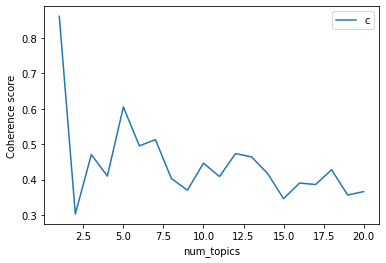

In [23]:
lmlist_lsi_spanish, c_v = evaluate_graph(dictionary=dictionary_spanish, corpus=corpus_spanish, texts=spanish_cleaned, limit=21, model= "lsi")

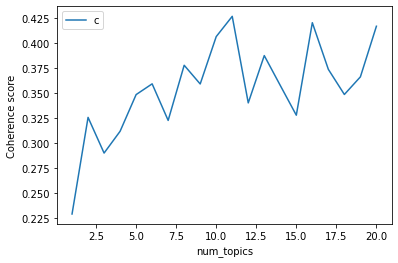

In [24]:
lmlist_lda_spanish, c_v = evaluate_graph(dictionary=dictionary_spanish, corpus=corpus_spanish, texts=spanish_cleaned, limit=21, model= "lda")

We do exactly the same for French and English

## French modelling

In [25]:
bigram = gensim.models.Phrases(french_texts)

In [ ]:
!python -m spacy download fr_core_news_md

In [26]:
nlp = spacy.load('/home/arturosanchez/Entornos_Virtuales/ea_assessment/lib/python3.6/site-packages/fr_core_news_md/fr_core_news_md-2.3.0')

In [27]:
def cleaner_french(french_texts,word, bigram, nlp):
    stop = set(stopwords.words('french'))
    stop_words = stop
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    list_word_clean = []
    for w1 in word.split(" "):
        if  w1.lower() not in stop_words:
            list_word_clean.append(w1.lower())
    bigram_list = bigram[list_word_clean]
    out_text = lemmatization_french(" ".join(bigram_list), stop_words, nlp)
    return out_text

In [28]:
def lemmatization_french(texts, stop_words, nlp, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stop_words and len(token.text)>2]
    return texts_out

In [29]:
french_cleaned = [cleaner_french(french_texts, x, bigram,nlp) for x in french_texts]

In [30]:
dictionary_french = Dictionary(french_cleaned)
dictionary_french.compactify()
dictionary_french.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary_french.compactify()

corpus_french = [dictionary_french.doc2bow(text) for text in french_cleaned]

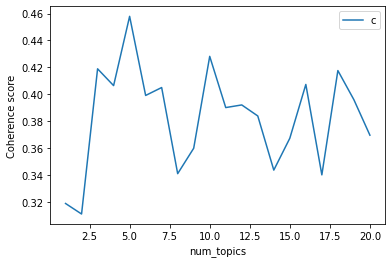

In [31]:
lmlist_lsi_french, c_v = evaluate_graph(dictionary=dictionary_french, corpus=corpus_french, texts=french_cleaned, limit=21, model= "lsi")

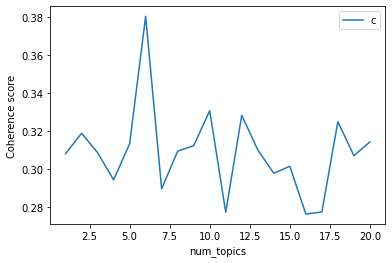

In [32]:
lmlist_lda_french, c_v = evaluate_graph(dictionary=dictionary_french, corpus=corpus_french, texts=french_cleaned, limit=21, model= "lda")

## English modelling

In [33]:
bigram = gensim.models.Phrases(english_texts)

In [ ]:
!python -m spacy download en_core_web_md

In [34]:
nlp = spacy.load('/home/arturosanchez/Entornos_Virtuales/ea_assessment/lib/python3.6/site-packages/en_core_web_md/en_core_web_md-2.3.1')

In [35]:
def cleaner_english(english_texts,word, bigram, nlp):
    stop = set(stopwords.words('english'))
    stop_words = stop
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    list_word_clean = []
    for w1 in word.split(" "):
        if  w1.lower() not in stop_words:
            list_word_clean.append(w1.lower())
    bigram_list = bigram[list_word_clean]
    out_text = lemmatization_english(" ".join(bigram_list), stop_words, nlp)
    return out_text

In [36]:
def lemmatization_english(texts, stop_words, nlp, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stop_words and len(token.text)>2]
    return texts_out

In [38]:
english_cleaned = [cleaner_english(english_texts, x, bigram, nlp) for x in english_texts]

In [39]:
dictionary_english = Dictionary(english_cleaned)
dictionary_english.compactify()
dictionary_english.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary_english.compactify()

corpus_english = [dictionary_english.doc2bow(text) for text in english_cleaned]

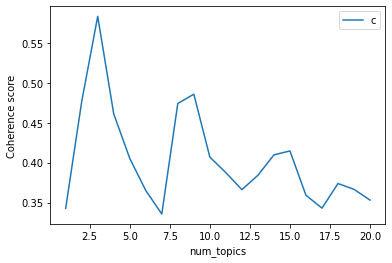

In [40]:
lmlist_lsi_english, c_v = evaluate_graph(dictionary=dictionary_english, corpus=corpus_english, texts=english_cleaned, limit=21, model= "lsi")

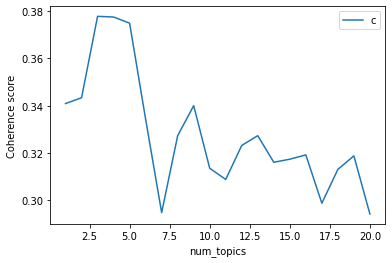

In [41]:
lmlist_lda_english, c_v = evaluate_graph(dictionary=dictionary_english, corpus=corpus_english, texts=english_cleaned, limit=21, model= "lda")

### Topic Extraction

Usually LDA models provide better results so we are going to build the LDA models. In addition LSI models seem to not agree very much on the number of topics. We build the LDA models using the number of topics that seem optimal accordin to the graphs. Spanish optimal number of topics (11) seems too high so we take 6 which is a suboptimal:

In [57]:
ldamodel_spanish = LdaModel(corpus=corpus_spanish, num_topics=6, id2word=dictionary_spanish)

In [50]:
ldamodel_french = LdaModel(corpus=corpus_french, num_topics=6, id2word=dictionary_french) 

In [43]:
ldamodel_english = LdaModel(corpus=corpus_english, num_topics=3, id2word=dictionary_english)

The following module  generates html files that allow us to explore the topics in a more interactive way. The conclusions from this exploration are written on the report.

In [46]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [48]:
import pyLDAvis.gensim
p_english = pyLDAvis.gensim.prepare(ldamodel_english, corpus_english, dictionary_english)

In [49]:
pyLDAvis.save_html(p_english, 'lda_english.html')

In [51]:
p_french = pyLDAvis.gensim.prepare(ldamodel_french, corpus_french, dictionary_french)
pyLDAvis.save_html(p_french, 'lda_french.html')

In [58]:
p_spanish = pyLDAvis.gensim.prepare(ldamodel_spanish, corpus_spanish, dictionary_spanish)
pyLDAvis.save_html(p_spanish, 'lda_spanish.html')